In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import tensorflow as tf

tf.compat.v1.enable_eager_execution()

In [4]:
x = tf.random.normal(shape = (1, 100))

In [5]:
tf.math.exp(tf.nn.log_softmax(x))

<tf.Tensor: id=7, shape=(1, 100), dtype=float32, numpy=
array([[0.00555614, 0.0049182 , 0.00798381, 0.00317804, 0.00678856,
        0.00440303, 0.00233651, 0.00913075, 0.00744909, 0.0065694 ,
        0.00060206, 0.0032713 , 0.00224006, 0.01225925, 0.01937592,
        0.01039682, 0.03665477, 0.01101448, 0.00852368, 0.00265814,
        0.00803169, 0.04099366, 0.00597613, 0.00437264, 0.00456577,
        0.01096538, 0.00251443, 0.00124698, 0.00405949, 0.00581776,
        0.00214754, 0.00809384, 0.00405603, 0.01221813, 0.00117233,
        0.01381907, 0.00274724, 0.00627036, 0.05921398, 0.02650197,
        0.00263057, 0.00031556, 0.00638939, 0.08120701, 0.02762496,
        0.00945178, 0.00731255, 0.00326247, 0.00458115, 0.00223708,
        0.02181498, 0.00259805, 0.00953586, 0.00912552, 0.00496112,
        0.00292532, 0.0014343 , 0.01012184, 0.00660645, 0.00320788,
        0.00407627, 0.03801437, 0.00733076, 0.00358716, 0.00846206,
        0.0056523 , 0.01097614, 0.0014338 , 0.02984708, 0.00

In [6]:
import malaya_speech.train.model.conformer as conformer
import malaya_speech.train.model.transducer as transducer
import malaya_speech
import tensorflow as tf
import numpy as np

In [7]:
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/v1/vocab/malaya-speech.tokenizer.subwords
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/pretrained/asr-small-conformer-output.tar.gz
# !tar -zxf asr-small-conformer-output.tar.gz
# !ls asr-small-conformer-output

In [8]:
subwords = malaya_speech.subword.load('transducer.tokenizer')

In [9]:
featurizer = malaya_speech.tf_featurization.STTFeaturizer(
    normalize_per_feature = True
)

In [10]:
files = [
    '../speech/record/savewav_2020-11-26_22-36-06_294832.wav',
    '../speech/record/savewav_2020-11-26_22-40-56_929661.wav',
    '../speech/record/675.wav',
    '../speech/record/664.wav',
    '../speech/example-speaker/husein-zolkepli.wav',
    '../speech/example-speaker/mas-aisyah.wav',
    '../speech/example-speaker/khalil-nooh.wav',
    '../speech/example-speaker/shafiqah-idayu.wav',
    '../speech/khutbah/wadi-annuar.wav',
]

ys = [malaya_speech.load(f)[0] for f in files[:1]]
padded, lens = malaya_speech.padding.sequence_1d(ys, return_len = True)

In [11]:
X = tf.convert_to_tensor(padded.astype(np.float32))
X_len = tf.convert_to_tensor(lens)

In [12]:
# X = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'X_placeholder')
# X_len = tf.compat.v1.placeholder(tf.int32, [None], name = 'X_len_placeholder')

In [13]:
batch_size = tf.shape(X)[0]
features = tf.TensorArray(dtype = tf.float32, size = batch_size, dynamic_size = True, infer_shape = False)
features_len = tf.TensorArray(dtype = tf.int32, size = batch_size)

init_state = (0, features, features_len)

def condition(i, features, features_len):
    return i < batch_size

def body(i, features, features_len):
    f = featurizer(X[i, :X_len[i]])
    f_len = tf.shape(f)[0]
    return i + 1, features.write(i, f), features_len.write(i, f_len)

_, features, features_len = tf.while_loop(condition, body, init_state)
features_len = features_len.stack()
padded_features = tf.TensorArray(dtype = tf.float32, size = batch_size)
padded_lens = tf.TensorArray(dtype = tf.int32, size = batch_size)
maxlen = tf.reduce_max(features_len)

init_state = (0, padded_features, padded_lens)

def condition(i, padded_features, padded_lens):
    return i < batch_size

def body(i, padded_features, padded_lens):
    f = features.read(i)
    len_f = tf.shape(f)[0]
    f = tf.pad(f, [[0, maxlen - tf.shape(f)[0]], [0,0]])
    return i + 1, padded_features.write(i, f), padded_lens.write(i, len_f)

_, padded_features, padded_lens = tf.while_loop(condition, body, init_state)
padded_features = padded_features.stack()
padded_lens = padded_lens.stack()
padded_lens.set_shape((None))
padded_features.set_shape((None, None, 80))
padded_features = tf.expand_dims(padded_features, -1)
padded_features, padded_lens

(<tf.Tensor: id=358, shape=(1, 598, 80, 1), dtype=float32, numpy=
 array([[[[-2.2245662 ],
          [-1.5762727 ],
          [-1.4157659 ],
          ...,
          [-0.84864193],
          [-0.5130596 ],
          [-0.53617686]],
 
         [[-1.2285241 ],
          [-1.4856597 ],
          [-1.3835925 ],
          ...,
          [-1.0460858 ],
          [-0.9751702 ],
          [-0.7758349 ]],
 
         [[-1.6258806 ],
          [-2.161505  ],
          [-2.1084962 ],
          ...,
          [-0.9996183 ],
          [-1.0397459 ],
          [-0.78438497]],
 
         ...,
 
         [[-1.2199712 ],
          [-1.447085  ],
          [-1.3426789 ],
          ...,
          [-0.62271357],
          [-0.5265967 ],
          [-0.93184185]],
 
         [[-1.8636333 ],
          [-2.130981  ],
          [-2.0027494 ],
          ...,
          [-0.595965  ],
          [-0.746562  ],
          [-0.48989078]],
 
         [[-0.7103715 ],
          [-1.2011461 ],
          [-1.1546397 ],
   

In [14]:
padded_features = tf.identity(padded_features, name = 'padded_features')
padded_lens = tf.identity(padded_lens, name = 'padded_lens')

In [15]:
config = malaya_speech.config.conformer_small_encoder_config
conformer_model = conformer.Model(**config)
decoder_config = malaya_speech.config.conformer_small_decoder_config
transducer_model = transducer.rnn.Model(
    conformer_model, vocabulary_size = subwords.vocab_size, **decoder_config
)

In [16]:
transducer_model.encoder.conv_subsampling.time_reduction_factor

4

In [17]:
# p = tf.compat.v1.placeholder(tf.int32, [None, None])
# z = tf.zeros((tf.shape(p)[0], 1),dtype=tf.int32)
# c = tf.concat([z, p], axis = 1)
# c

In [18]:
p = tf.constant([[2,2,2,2,2]])
z = tf.zeros((tf.shape(p)[0], 1),dtype=tf.int32)
c = tf.concat([z, p], axis = 1)
c

<tf.Tensor: id=373, shape=(1, 6), dtype=int32, numpy=array([[0, 2, 2, 2, 2, 2]], dtype=int32)>

In [19]:
l = tf.constant([6])

In [20]:
logits = transducer_model([padded_features, c, l], training = False)
logits


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Tensor: id=12622, shape=(1, 150, 6, 1019), dtype=float32, numpy=
array([[[[-0.44402975,  0.43671367, -0.4971884 , ..., -0.15641461,
           0.30380902,  0.00193681],
         [-0.34389183,  0.622414  , -0.44988954, ..., -0.06882282,
           0.17790644,  0.17786662],
         [-0.28181666,  0.72993344, -0.41961455, ..., -0.0158148 ,
           0.06247481,  0.28637314],
         [-0.24432124,  0.79271376, -0.41217506, ...,  0.01499708,
          -0.03208706,  0.3518416 ],
         [-0.22049505,  0.8326632 , -0.41824165, ...,  0.03413409,
          -0.10767457,  0.3935852 ],
         [-0.20472051,  0.8599612 , -0.4311045 , ...,  0.04658622,
          -0.16788161,  0.4217404 ]],

        [[-0.3847059 ,  0.36242586, -0.5694346 , ..., -0.38109237,
           0.26851162,  0.11176512],
         [-0.26039642,  0.55903876, -0.5082668 , ..., -0.29177108,
           0.138309  ,  0.30559492],
         [-0.18268086,  0.6725719 , -0.46792224, ..., -0.23437233,
           0.03200337,  0.4196

In [21]:
transducer_model.load_weights('asr-small-conformer-output/model.ckpt')

InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on asr-small-conformer-output/model.ckpt: Not found: asr-small-conformer-output; No such file or directory

In [22]:
decoded = transducer_model.greedy_decoder(padded_features, padded_lens, training = False)
# decoded = tf.identity(decoded, name = 'greedy_decoder')
decoded

(<tf.Tensor: id=59430, shape=(1, 149), dtype=int32, numpy=
 array([[368, 368, 716, 716, 716, 139, 139, 139, 139, 139, 131, 139, 131,
         270, 311, 716, 368, 716, 368, 368, 368, 365, 368, 368, 311, 716,
         716, 716, 716, 139, 139, 139, 139, 131, 139, 139, 131, 139, 131,
         808, 368, 368, 368, 368, 368, 433, 311, 716, 311, 716, 716, 139,
         139, 426, 368, 368, 368, 368, 311, 716, 311, 716, 716, 139, 139,
         139, 426, 368, 368, 368, 368, 433, 368, 311, 716, 716, 508, 716,
         716, 139, 139, 139, 131, 270, 311, 716, 139, 139, 139, 368, 368,
         368, 433, 368, 311, 508, 716, 716, 716, 368, 716, 368, 368, 365,
         368, 368, 365, 368, 368, 365, 368, 368, 365, 368, 368, 433, 311,
         716, 716, 139, 139, 139, 426, 368, 368, 368, 368, 433, 368, 311,
         716, 368, 716, 311, 716,  67, 716,  67, 716, 546, 139, 139, 139,
         139, 368, 368, 368, 368, 433]], dtype=int32)>,
 <tf.Tensor: id=59446, shape=(1, 149, 1019), dtype=float32, numpy=
 arr

In [41]:
r = transducer_model.greedy_decoder_alignment(padded_features[:1], padded_lens[:1], training = False)

In [42]:
last_index = np.where(r[0].numpy() > 0)[1][-1]
last_index

140

In [43]:
l = r[0].numpy()[0,:last_index]
r = np.exp(r[1].numpy()[0,:last_index])

In [57]:
r.shape

(140, 1019)

In [56]:
s = tf.nn.softmax(r[:,l]).numpy()
s.shape

(140, 140)

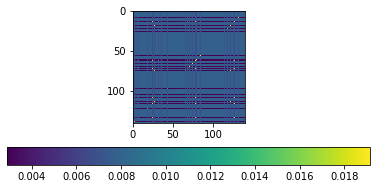

In [64]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(s), interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [ ]:
encoded = transducer_model.encoder_inference(padded_features[0])
encoded

In [ ]:
encoded

In [ ]:
g = transducer_model._perform_greedy(encoded, tf.shape(encoded)[0],
                                tf.constant(0, dtype = tf.int32),
                                transducer_model.predict_net.get_initial_state())
g

In [ ]:
indices = g.prediction
minus_one = -1 * tf.ones_like(indices, dtype=tf.int32)
blank_like = 0 * tf.ones_like(indices, dtype=tf.int32)
indices = tf.where(indices == minus_one, blank_like, indices)

In [ ]:
num_samples = tf.cast(tf.shape(X[0])[0], dtype=tf.float32)
total_time_reduction_factor = featurizer.frame_step
stime = tf.range(0, num_samples, delta=total_time_reduction_factor, dtype=tf.float32)
stime /= tf.cast(featurizer.sample_rate, dtype=tf.float32)
etime = tf.range(total_time_reduction_factor, num_samples, delta=total_time_reduction_factor, dtype=tf.float32)
etime /= tf.cast(featurizer.sample_rate, dtype=tf.float32)
non_blank = tf.where(tf.not_equal(indices, 0))
non_blank_transcript = tf.gather_nd(indices, non_blank)
non_blank_stime = tf.gather_nd(tf.repeat(tf.expand_dims(stime, axis=-1), tf.shape(indices)[-1], axis=-1), non_blank)[:,0]

In [ ]:
malaya_speech.subword.decode(subwords, non_blank_transcript.numpy())

In [ ]:
subwords._id_to_subword(596 - 1), subwords._id_to_subword(206 - 1)

In [ ]:
non_blank_transcript

In [ ]:
non_blank_stime

In [ ]:
# beam_width = tf.placeholder(tf.int32, None, name = 'beam_width')
# decoded_beam = transducer_model.beam_decoder(padded_features, padded_lens, 
#                                              beam_width = beam_width, training = False)
# decoded_beam = tf.identity(decoded_beam, name = 'beam_decoder')
# decoded_beam

In [ ]:
encoded = transducer_model.encoder(padded_features, training = False)
encoded = tf.identity(encoded, name = 'encoded')
encoded_placeholder = tf.placeholder(tf.float32, [config['dmodel']], name = 'encoded_placeholder')
predicted_placeholder = tf.placeholder(tf.int32, None, name = 'predicted_placeholder')
t = transducer_model.predict_net.get_initial_state().shape
states_placeholder = tf.placeholder(tf.float32, [int(i) for i in t], name = 'states_placeholder')

ytu, new_states = transducer_model.decoder_inference(
    encoded=encoded_placeholder,
    predicted=predicted_placeholder,
    states=states_placeholder,
    training = True
)

ytu = tf.identity(ytu, name = 'ytu')
new_states = tf.identity(new_states, name = 'new_states')
ytu, new_states

In [ ]:
initial_states = transducer_model.predict_net.get_initial_state()
initial_states = tf.identity(initial_states, name = 'initial_states')

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
saver = tf.train.Saver(var_list = var_list)
saver.restore(sess, 'asr-small-conformer-output/model.ckpt')

In [ ]:
r = sess.run([non_blank_transcript, non_blank_stime, non_blank_etime], feed_dict = {X: padded, X_len: lens})
r

In [ ]:
r[0].shape

In [ ]:
r[2].shape

In [ ]:
import collections
import numpy as np
import tensorflow as tf

BeamHypothesis = collections.namedtuple(
    'BeamHypothesis', ('score', 'prediction', 'states')
)


def transducer(
    enc,
    total,
    initial_states,
    encoded_placeholder,
    predicted_placeholder,
    states_placeholder,
    ytu,
    new_states,
    sess,
    beam_width = 10,
    norm_score = True,
):
    kept_hyps = [
        BeamHypothesis(score = 0.0, prediction = [0], states = initial_states)
    ]
    B = kept_hyps
    for i in range(total):
        A = B
        B = []
        while True:
            y_hat = max(A, key = lambda x: x.score)
            A.remove(y_hat)
            ytu_, new_states_ = sess.run(
                [ytu, new_states],
                feed_dict = {
                    encoded_placeholder: enc[i],
                    predicted_placeholder: y_hat.prediction[-1],
                    states_placeholder: y_hat.states,
                },
            )
            for k in range(ytu_.shape[0]):
                beam_hyp = BeamHypothesis(
                    score = (y_hat.score + float(ytu_[k])),
                    prediction = y_hat.prediction,
                    states = y_hat.states,
                )
                if k == 0:
                    B.append(beam_hyp)
                else:
                    beam_hyp = BeamHypothesis(
                        score = beam_hyp.score,
                        prediction = (beam_hyp.prediction + [int(k)]),
                        states = new_states_,
                    )
                    A.append(beam_hyp)
            if len(B) > beam_width:
                break
    if norm_score:
        kept_hyps = sorted(
            B, key = lambda x: x.score / len(x.prediction), reverse = True
        )[:beam_width]
    else:
        kept_hyps = sorted(B, key = lambda x: x.score, reverse = True)[
            :beam_width
        ]
    return kept_hyps[0].prediction

In [ ]:
%%time

r = sess.run(decoded, feed_dict = {X: padded, X_len: lens})
for row in r:
    print(malaya_speech.subword.decode(subwords, row[row > 0]))

In [ ]:
%%time

encoded_, padded_lens_  = sess.run([encoded, padded_lens], feed_dict = {X: padded, X_len: lens})
padded_lens_ = padded_lens_ // conformer_model.conv_subsampling.time_reduction_factor
s = sess.run(initial_states)

for i in range(len(encoded_)):
    r = transducer(
        enc = encoded_[i],
        total = padded_lens_[i],
        initial_states = s,
        encoded_placeholder = encoded_placeholder,
        predicted_placeholder = predicted_placeholder,
        states_placeholder = states_placeholder,
        ytu = ytu,
        new_states = new_states,
        sess = sess,
        beam_width = 1,
    )

    print(malaya_speech.subword.decode(subwords, r))

In [ ]:
saver = tf.train.Saver()
saver.save(sess, 'output/model.ckpt')

In [ ]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'placeholder' in n.name
        or 'encoded' in n.name
        or 'decoder' in n.name
        or 'ytu' in n.name
        or 'new_states' in n.name
        or 'padded_' in n.name
        or 'initial_states' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
    ]
)
strings.split(',')

In [ ]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [ ]:
freeze_graph('output', strings)

In [ ]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [ ]:
g = load_graph('output/frozen_model.pb')

In [ ]:
input_nodes = [
    'X_placeholder',
    'X_len_placeholder',
    'encoded_placeholder',
    'predicted_placeholder',
    'states_placeholder',
]
output_nodes = [
    'greedy_decoder',
    'encoded',
    'ytu',
    'new_states',
    'padded_features',
    'padded_lens',
    'initial_states'
]
inputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in input_nodes}
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [ ]:
test_sess = tf.InteractiveSession(graph = g)

In [ ]:
r = test_sess.run(outputs['greedy_decoder'], feed_dict = {inputs['X_placeholder']: padded, 
                                                          inputs['X_len_placeholder']: lens})

In [ ]:
for row in r:
    print(malaya_speech.subword.decode(subwords, row[row > 0]))

In [ ]:
encoded_, padded_lens_, s  = test_sess.run([outputs['encoded'], outputs['padded_lens'], outputs['initial_states']], 
                                        feed_dict = {inputs['X_placeholder']: padded, 
                                                     inputs['X_len_placeholder']: lens})

padded_lens_ = padded_lens_ // conformer_model.conv_subsampling.time_reduction_factor

In [ ]:
i = 0
r = transducer(
    enc = encoded_[i],
    total = padded_lens_[i],
    initial_states = s,
    encoded_placeholder = inputs['encoded_placeholder'],
    predicted_placeholder = inputs['predicted_placeholder'],
    states_placeholder = inputs['states_placeholder'],
    ytu = outputs['ytu'],
    new_states = outputs['new_states'],
    sess = test_sess,
    beam_width = 1,
)

malaya_speech.subword.decode(subwords, r)

In [ ]:
from tensorflow.tools.graph_transforms import TransformGraph

In [ ]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics, op=Dropout)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-10, fallback_max=10)',
             'strip_unused_nodes',
             'sort_by_execution_order']

pb = 'output/frozen_model.pb'

input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           input_nodes,
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

In [ ]:
g = load_graph('output/frozen_model.pb.quantized')

In [ ]:
inputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in input_nodes}
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}
test_sess = tf.InteractiveSession(graph = g)

In [ ]:
r = test_sess.run(outputs['greedy_decoder'], feed_dict = {inputs['X_placeholder']: padded, 
                                                          inputs['X_len_placeholder']: lens})

In [ ]:
for row in r:
    print(malaya_speech.subword.decode(subwords, row[row > 0]))

In [ ]:
encoded_, padded_lens_, s  = test_sess.run([outputs['encoded'], outputs['padded_lens'], outputs['initial_states']], 
                                        feed_dict = {inputs['X_placeholder']: padded, 
                                                     inputs['X_len_placeholder']: lens})

padded_lens_ = padded_lens_ // conformer_model.conv_subsampling.time_reduction_factor

In [ ]:
i = 0
r = transducer(
    enc = encoded_[i],
    total = padded_lens_[i],
    initial_states = s,
    encoded_placeholder = inputs['encoded_placeholder'],
    predicted_placeholder = inputs['predicted_placeholder'],
    states_placeholder = inputs['states_placeholder'],
    ytu = outputs['ytu'],
    new_states = outputs['new_states'],
    sess = test_sess,
    beam_width = 1,
)

malaya_speech.subword.decode(subwords, r)

In [ ]:
# !rm -rf output asr-small-conformer-output